In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]

In [5]:
TdayTotalIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3)

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_127/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #cut at a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_127/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_127/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
#     GasMasses = sim['SnapNumber_127/PartType0/Masses'][IndexT_near]
#     GassAbundances = sim['SnapNumber_127/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_near]

    #re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # The rotations matrix are, for velocity
    faV = (1-velx)/(vely**2+ velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    #the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # return the 2 sets of rotated positions, masses and abundances
#     return xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GassAbundances # not yet
    return xRv, yRv, zRv, xRc, yRc, zRc 

In [7]:
import progressbar

In [8]:
# separate the satellites by their properties
# stellar mass and distance to the BGG, for instance.
stMass, distToC = [], []

for sat, cen in zip(Satellites, Centrals):
    StOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][sat].astype('int')
    
    posS = sim['SnapNumber_128/SubGroups/SubGroupPos'][sat]
    posC = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

    dif = np.sqrt(np.sum((posS - posC)**2))
    distToC.append(dif)
    
    st = sim['SnapNumber_128/PartType4/Masses'][StOff[0]:StOff[1]]
    stMass.append(np.sum(st))
    
stMass, distToC = np.array(stMass), np.array(distToC)

In [9]:
# select subgroup of galaxies
ism = np.where(stMass>0)

SatWS, CenWS, stMass = Satellites[ism], Centrals[ism], stMass[ism] # central and satellites with stars

medDist = np.median(distToC)
medStM = np.median(stMass)

iSm1, iSm2 = np.where(stMass<medStM), np.where(stMass>medStM)
iDist1, iDist2 = np.where(distToC<medDist), np.where(distToC>medDist)

SatSMass1, CenSMass1, SatSMass2, CenSMass2 = SatWS[iSm1], CenWS[iSm1], SatWS[iSm2], CenWS[iSm2]
SatDist1, CenDist1, SatDist2, CenDist2 = Satellites[iDist1], Centrals[iDist1], Satellites[iDist2], Centrals[iDist2]

  5% (7 of 118) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:56<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
100% (118 of 118) |######################| Elapsed Time: 0:03:00 ETA:  00:00:00

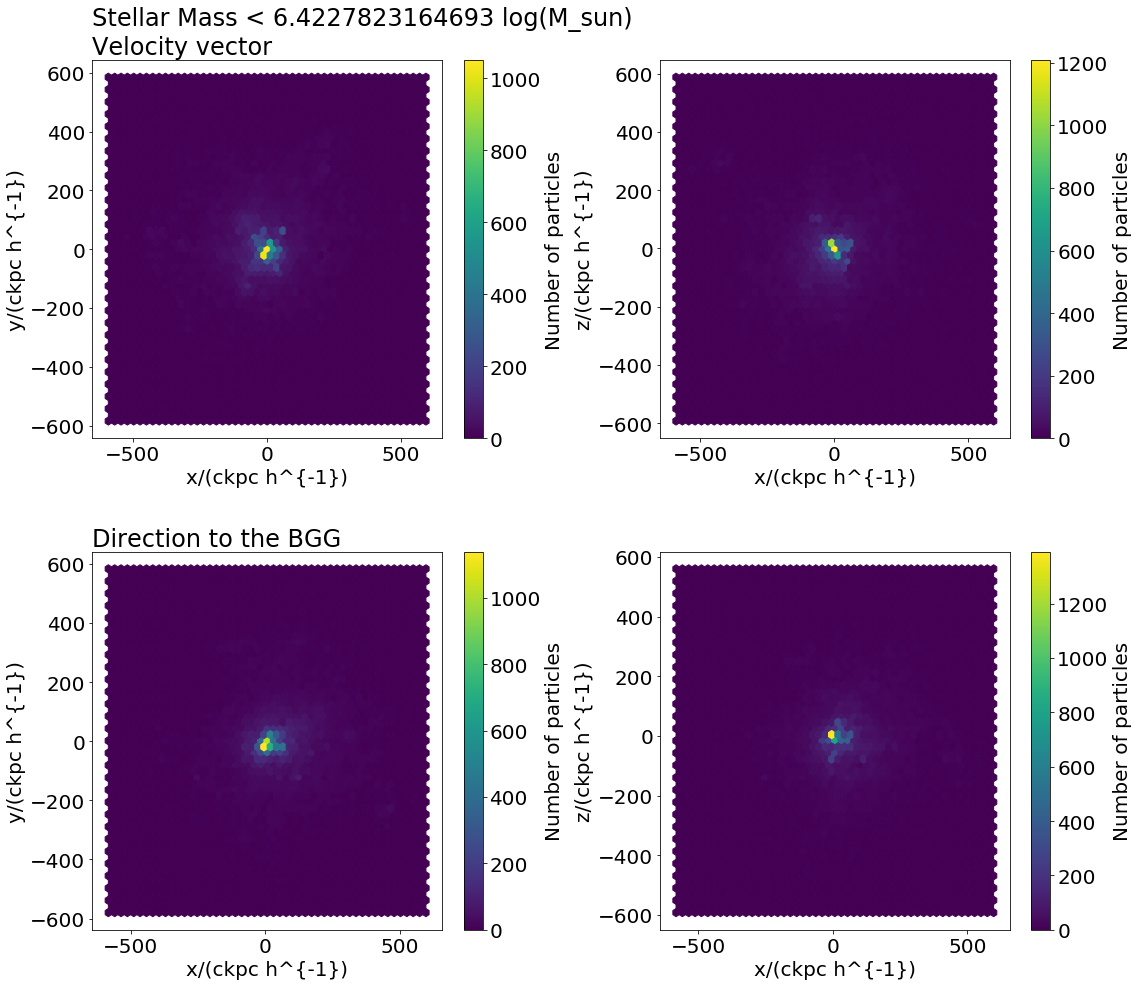

In [10]:
# low stellar mass first

size = SatSMass1.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatSMass1, CenSMass1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Stellar Mass < {} log(M_sun)\nVelocity vector'.format(np.log10(medStM*1e10)),loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')


 57% (68 of 118) |#############          | Elapsed Time: 0:03:40 ETA:   0:01:49<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
100% (118 of 118) |######################| Elapsed Time: 0:16:52 ETA:  00:00:00

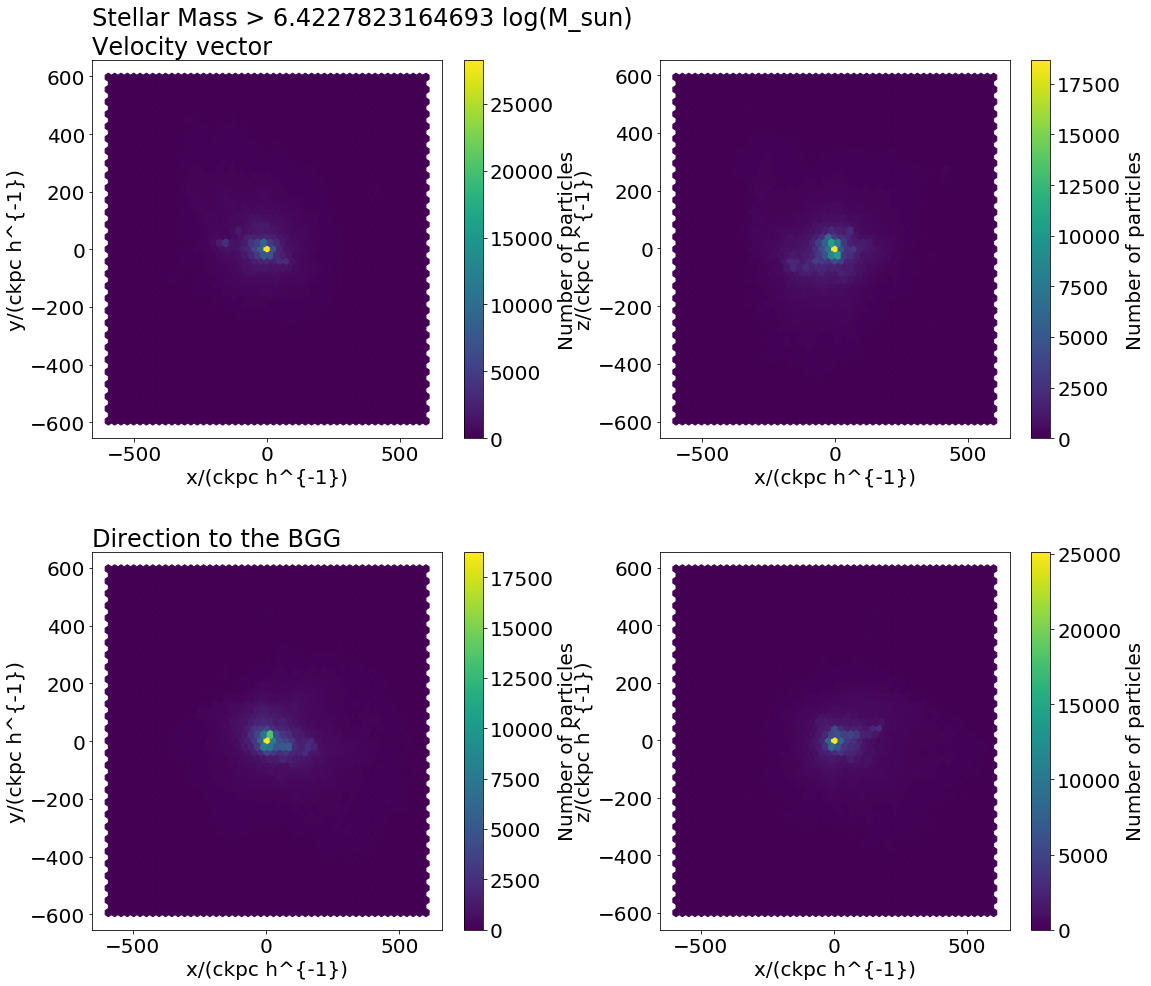

In [11]:
# high stellar mass

size = SatSMass2.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatSMass2, CenSMass2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Stellar Mass > {} log(M_sun)\nVelocity vector'.format(np.log10(medStM*1e10)),loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')


N/A% (0 of 506) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
 98% (500 of 506) |##################### | Elapsed Time: 0:05:02 ETA:   0:00:00

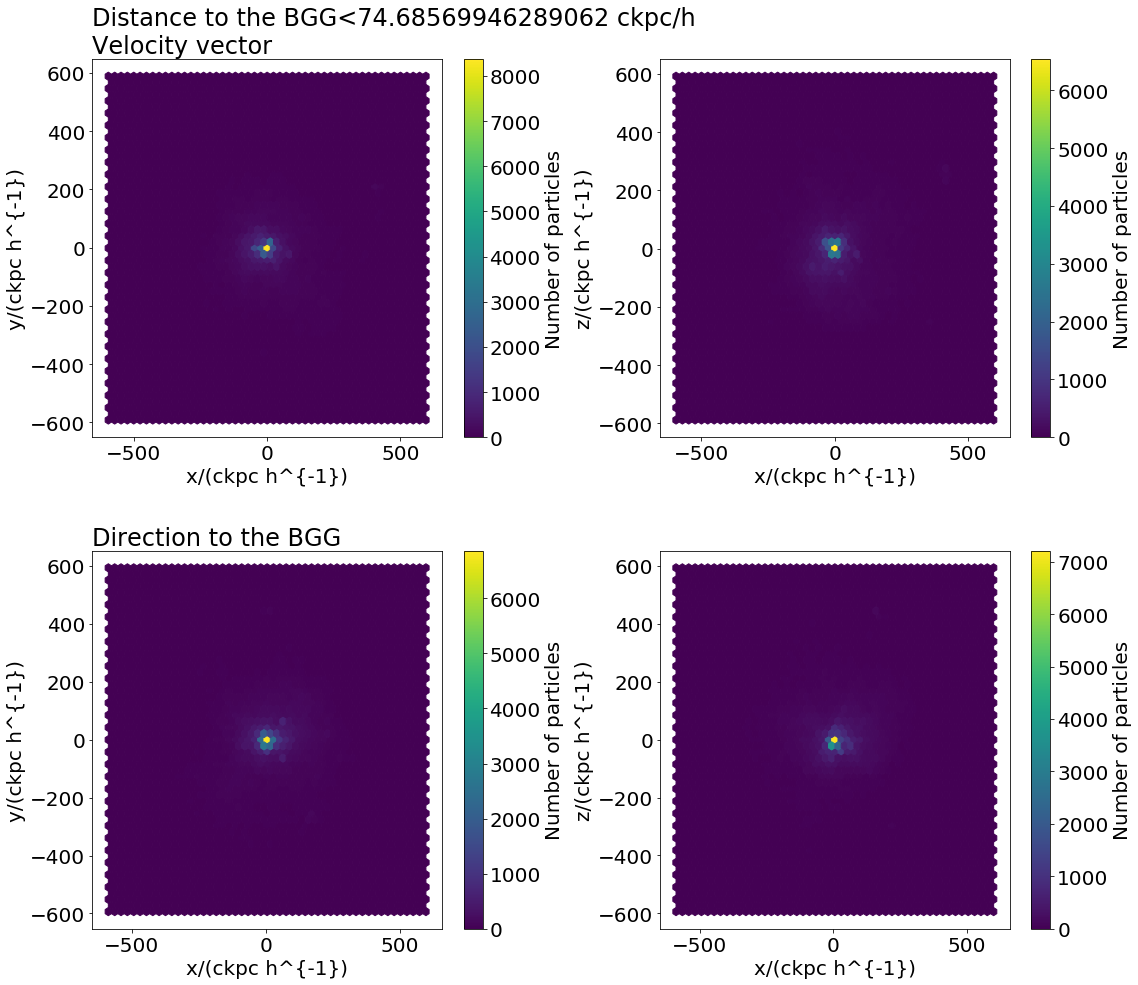

In [12]:
# low distances

size = SatDist1.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatDist1, CenDist1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

# and teh four graphs
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the BGG<{} ckpc/h\nVelocity vector'.format(medDist), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

 99% (504 of 506) |##################### | Elapsed Time: 0:17:57 ETA:   0:00:01

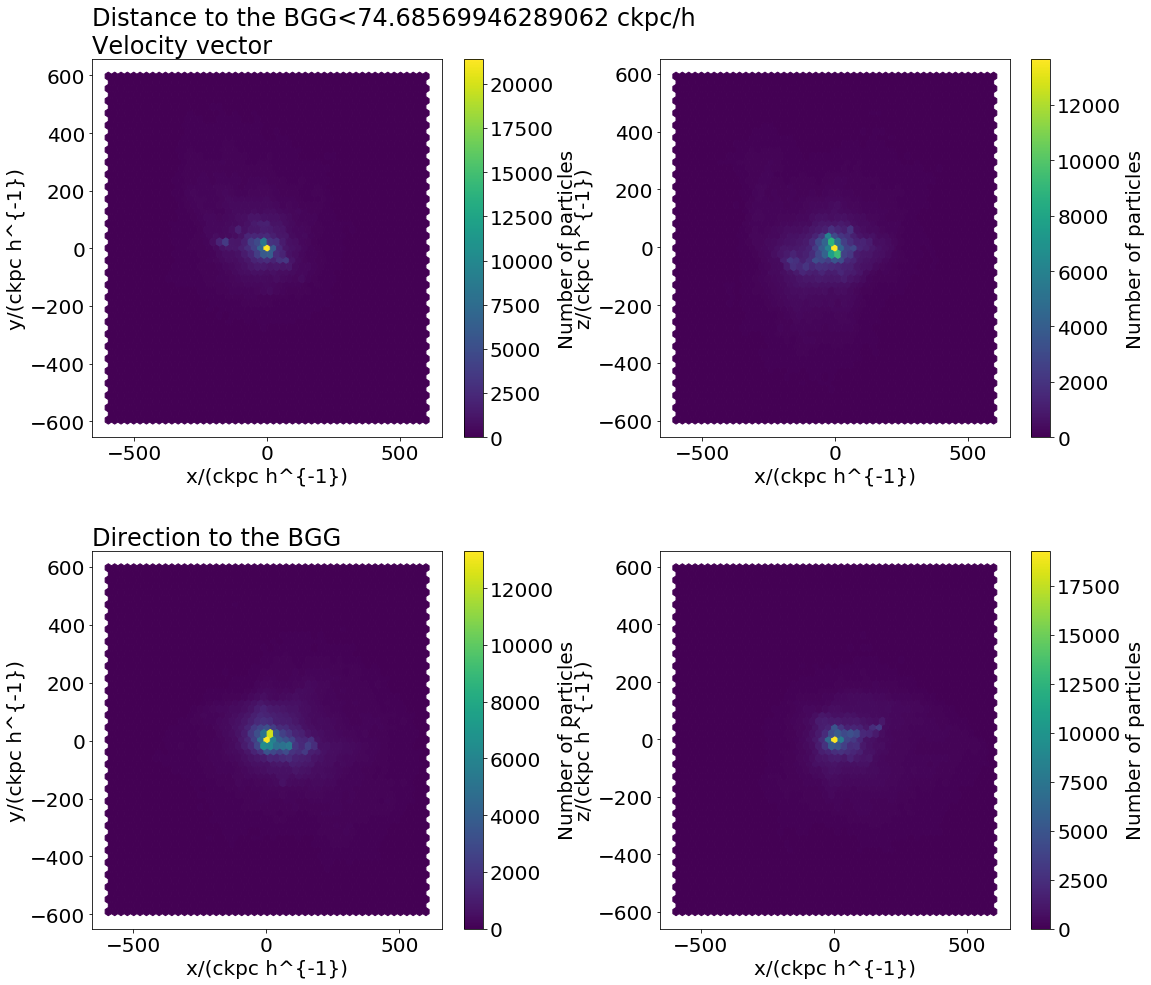

In [13]:
# high distances

size = SatDist2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatDist2, CenDist2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the BGG<{} ckpc/h\nVelocity vector'.format(medDist), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

In [14]:
distToRC, distToRC200= [], []

for sat, cen in zip(Satellites, Centrals):
    posS = sim['SnapNumber_128/SubGroups/SubGroupPos'][sat]
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]

    posGroup = sim['SnapNumber_128/Groups/GroupCM'][group]
    R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    dif = np.sqrt(np.sum((posS - posGroup)**2))
    
    distToRC.append(dif)
    
    difr200 = dif/R200
    
    distToRC200.append(difr200)
    
distToRC, distToRC200 = np.array(distToRC), np.array(distToRC200)

<ipython-input-14-e3215c4a975f>:15: RuntimeWarning: divide by zero encountered in float_scalars
  difr200 = dif/R200


In [15]:
i = np.where(distToRC200!=np.inf)
distToRC200 = distToRC200[i]

SatR200, CenR200 = Satellites[i], Centrals[i]

In [16]:
medRC = np.median(distToRC)
medR200 = np.median(distToRC200)

iR1, iR2 = np.where(distToRC<medRC), np.where(distToRC>medRC)
iR200_1, iR200_2 = np.where(distToRC200<medR200), np.where(distToRC200>medR200)

SatRC1, CentRC1 = Satellites[iR1], Centrals[iR1]
SatRC2, CentRC2 = Satellites[iR2], Centrals[iR2]

SatR200_1, CentR200_1 = SatR200[iR200_1], CenR200[iR200_1]
SatR200_2, CentR200_2 = SatR200[iR200_2], CenR200[iR200_2]

  2% (12 of 506) |                       | Elapsed Time: 0:00:11 ETA:   0:08:43<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
 98% (500 of 506) |##################### | Elapsed Time: 0:12:10 ETA:   0:00:00

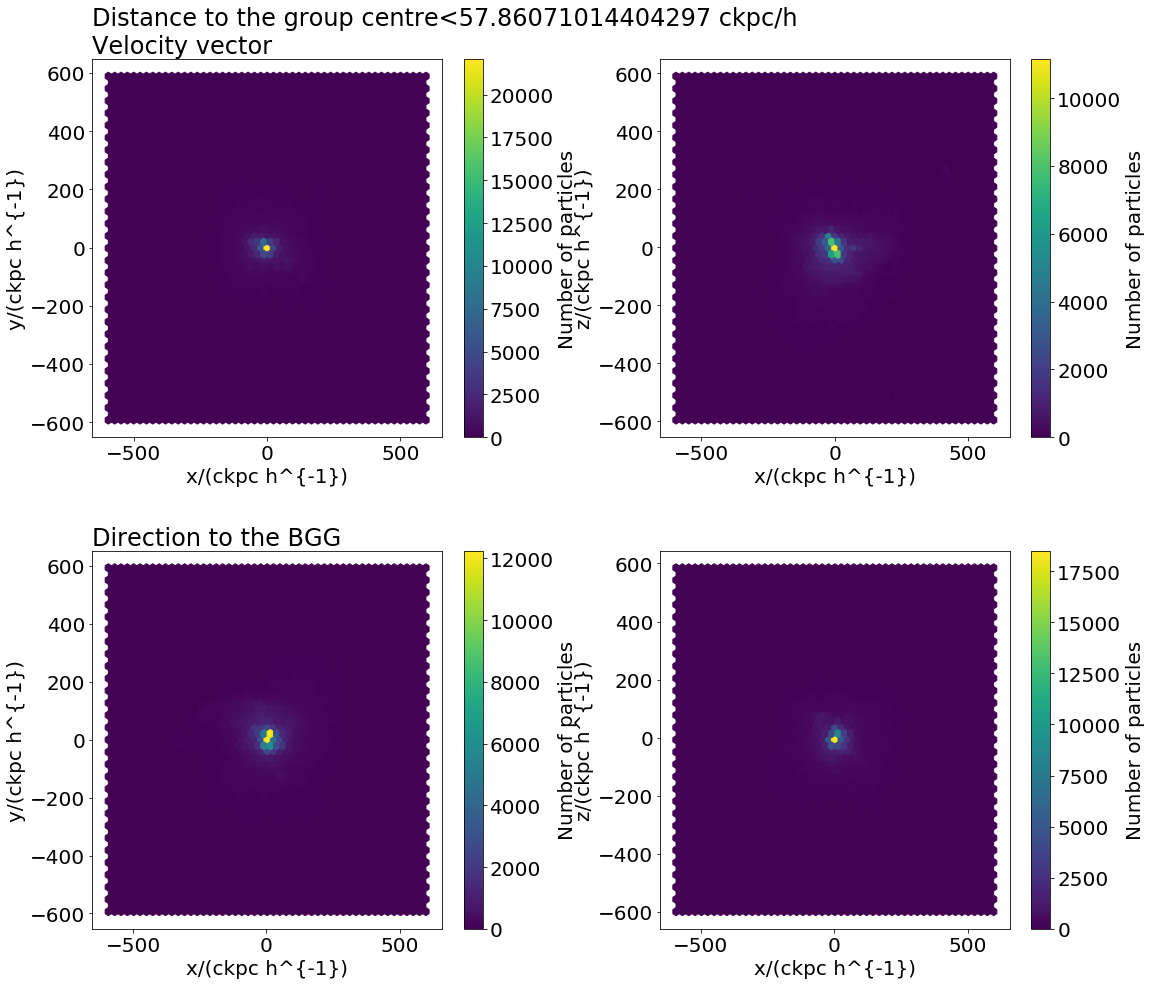

In [17]:
# low distances to the centre of the group
size = SatRC1.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatRC1, CentRC1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))


pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the group centre<{} ckpc/h\nVelocity vector'.format(medRC), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

  3% (20 of 506) |                       | Elapsed Time: 0:00:05 ETA:   0:02:04<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
 99% (504 of 506) |##################### | Elapsed Time: 0:10:50 ETA:   0:00:00

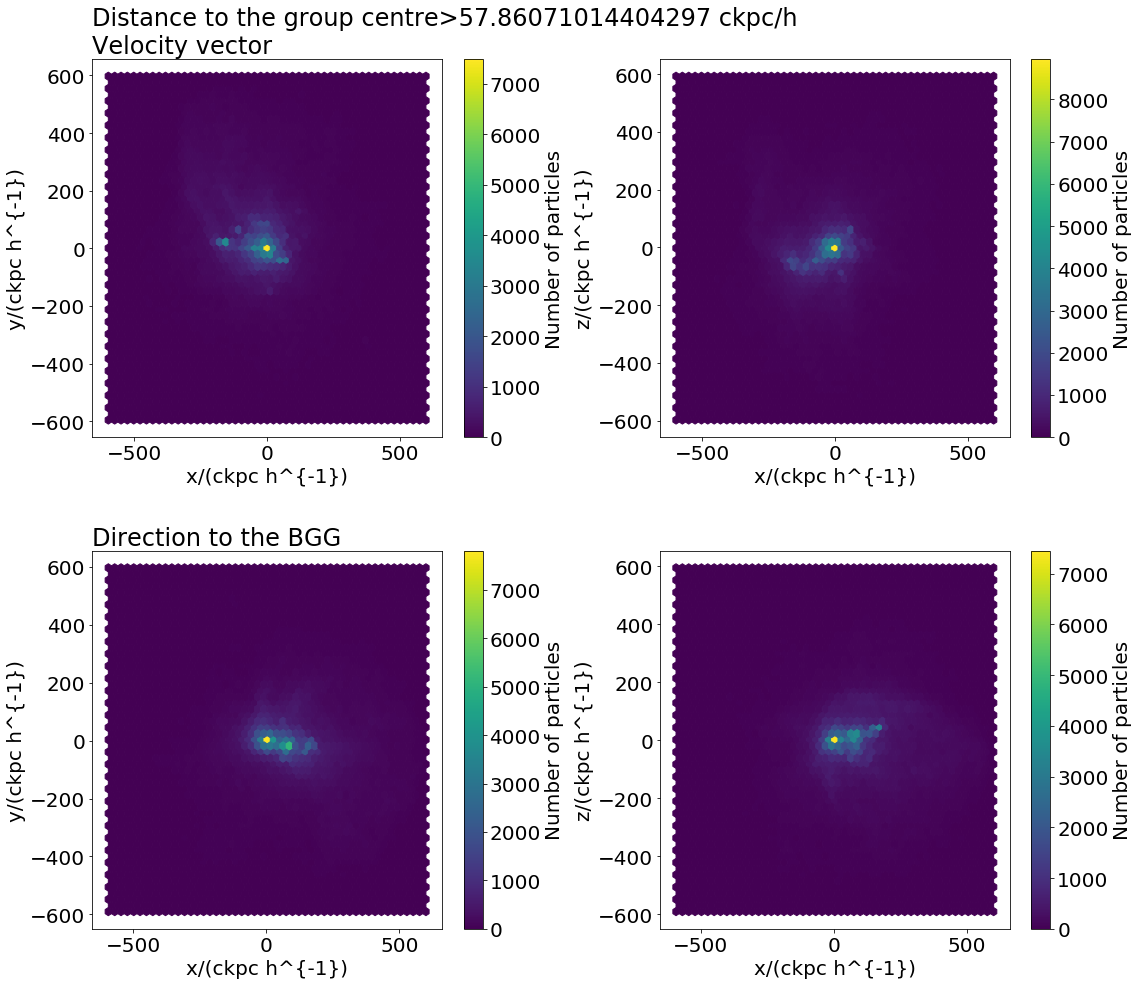

In [18]:
# low distances to the centre of the group

size = SatRC2.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatRC2, CentRC2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the group centre>{} ckpc/h\nVelocity vector'.format(medRC), loc='left')
# pl.title('Velocity vector',loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

  3% (18 of 505) |                       | Elapsed Time: 0:00:08 ETA:   0:01:34<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
 99% (504 of 505) |##################### | Elapsed Time: 0:16:26 ETA:   0:00:00

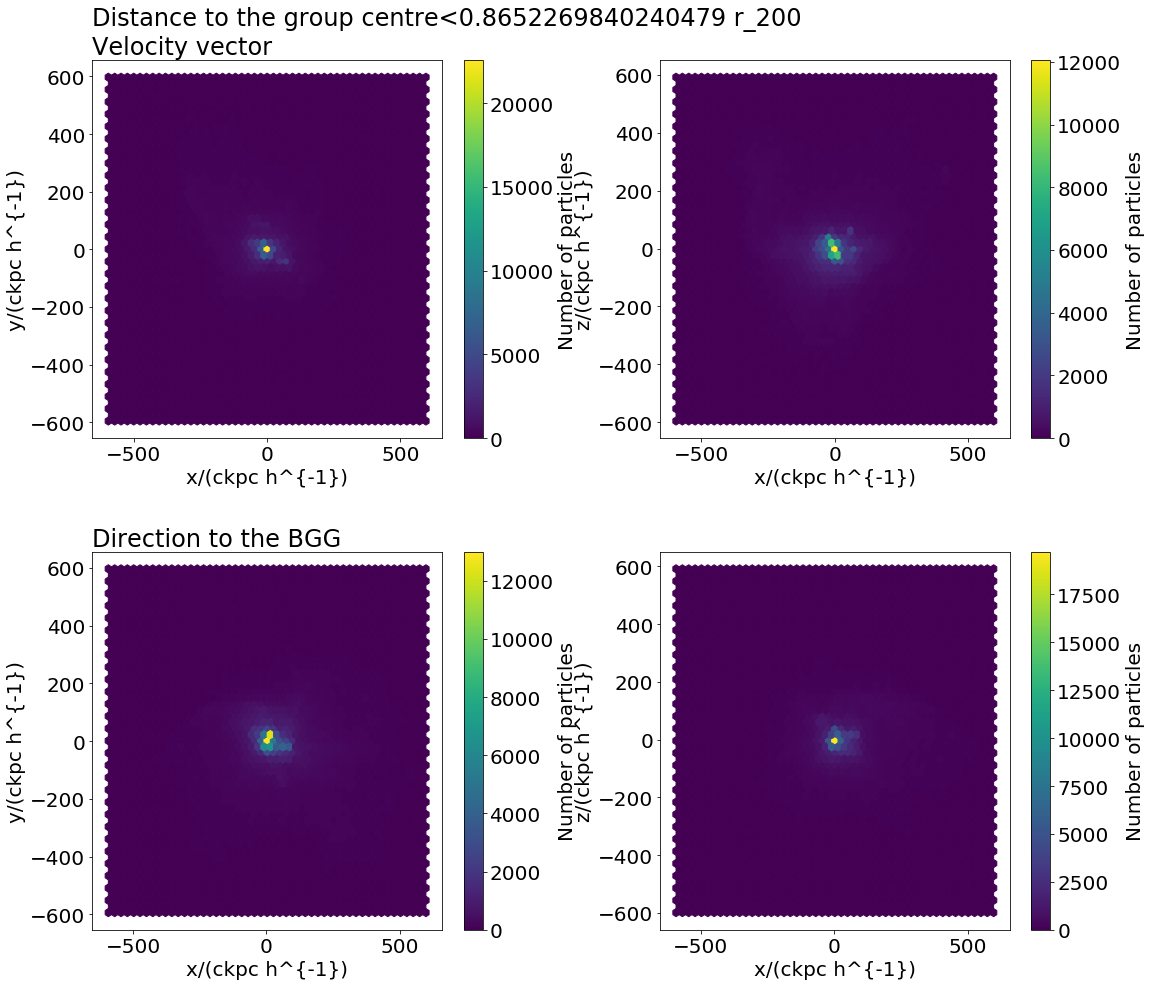

In [19]:
# low distances to the centre (in r_200)
size = SatR200_1.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatR200_1, CentR200_1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))


pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the group centre<{} r_200\nVelocity vector'.format(medR200), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

  5% (30 of 505) |#                      | Elapsed Time: 0:00:28 ETA:   0:03:25<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
 98% (499 of 505) |##################### | Elapsed Time: 0:06:45 ETA:   0:00:01

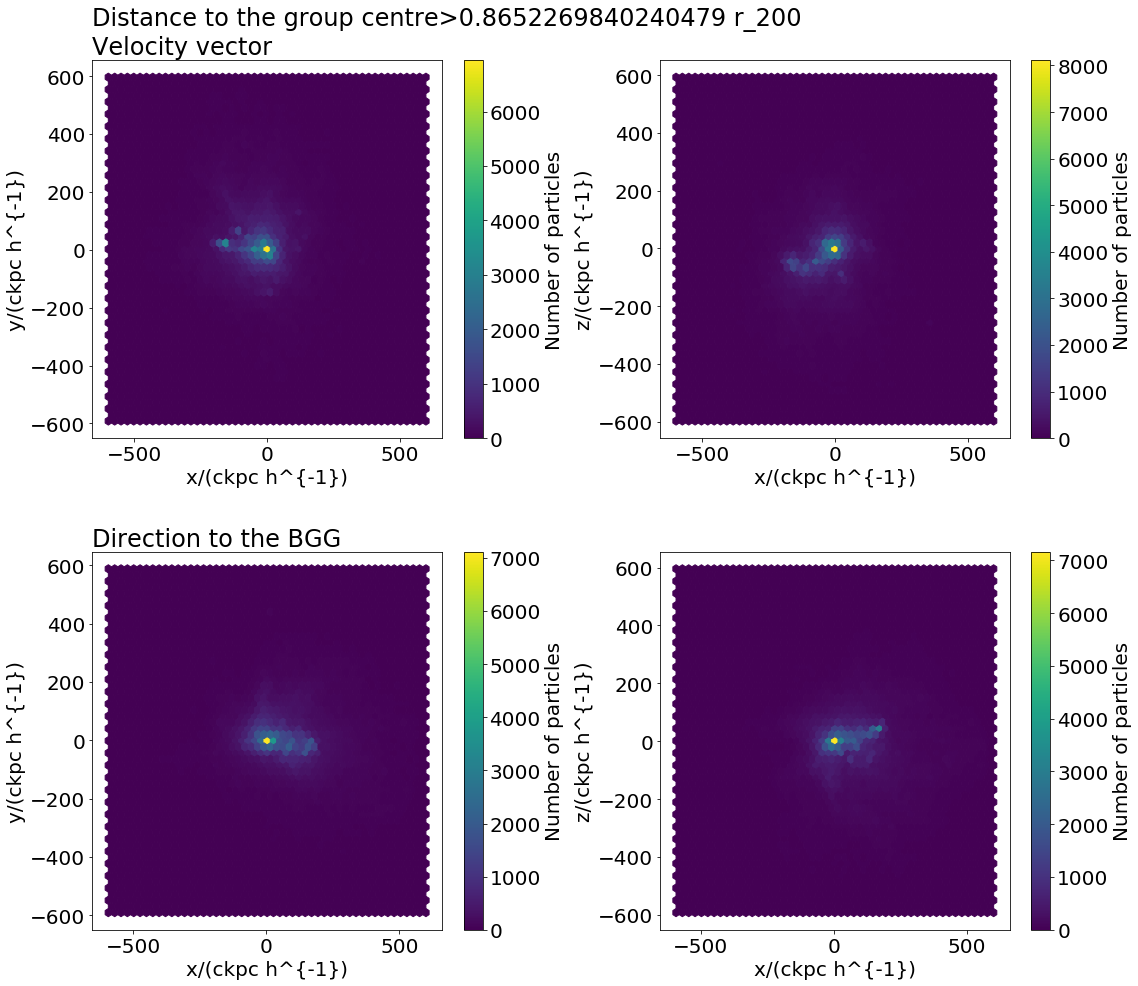

In [20]:
# high distances to the centre (in r_200)
size = SatR200_2.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatR200_2, CentR200_2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))


pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the group centre>{} r_200\nVelocity vector'.format(medR200), loc='left')
    
pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

In [28]:
distR200 = []

for sat, cen in zip(Satellites, Centrals):
    posS = sim['SnapNumber_128/SubGroups/SubGroupPos'][sat]
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]

    posGroup = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
    R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    dif = np.sqrt(np.sum((posS - posGroup)**2))
    
    difr200 = dif/R200
    
    distR200.append(difr200)
    
distR200 = np.array(distR200)

<ipython-input-28-7d62bf8f56a8>:13: RuntimeWarning: invalid value encountered in float_scalars
  difr200 = dif/R200


In [33]:
i = np.where((distR200!=np.inf) & (np.isnan(distR200)==False))

distR200 = distR200[i]
SatR20, CentR20 = Satellites[i], Centrals[i]

distR200.min(), distR200.max()

(0.0, 73.42453)

In [34]:
medR20 = np.median(distR200)

i1, i2 = np.where(distR200<medR20), np.where(distR200>medR20)

SatR20_1, CentR20_1 = SatR20[i1], CentR20[i1]
SatR20_2, CentR20_2 = SatR20[i2], CentR20[i2]

  1% (7 of 505) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
 98% (499 of 505) |##################### | Elapsed Time: 0:12:20 ETA:   0:00:01

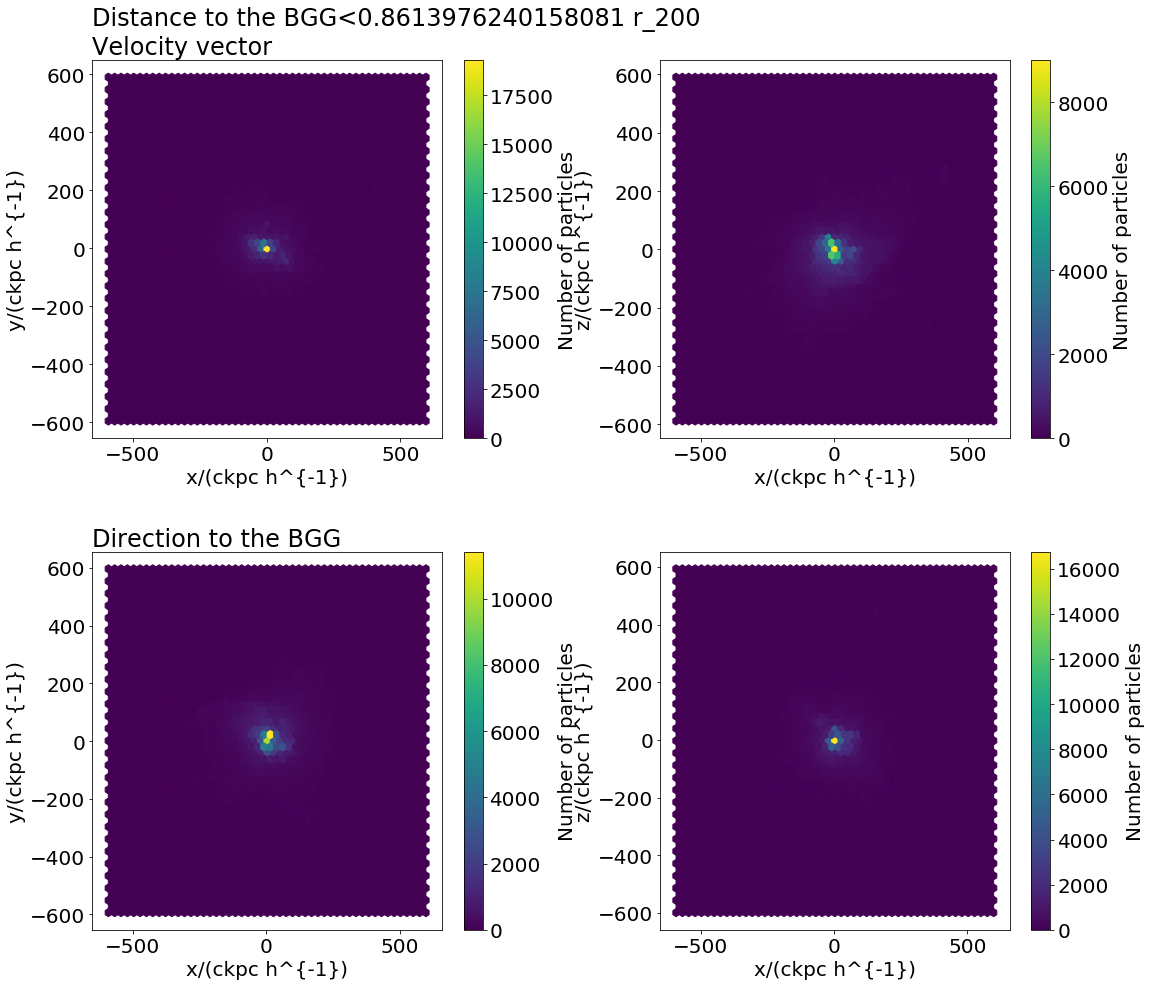

In [35]:
# low distances to the BGG (in r_200)
size = SatR20_1.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatR20_1, CentR20_1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))


pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the BGG<{} r_200\nVelocity vector'.format(medR20), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

100% (505 of 505) |######################| Elapsed Time: 0:10:51 ETA:  00:00:00

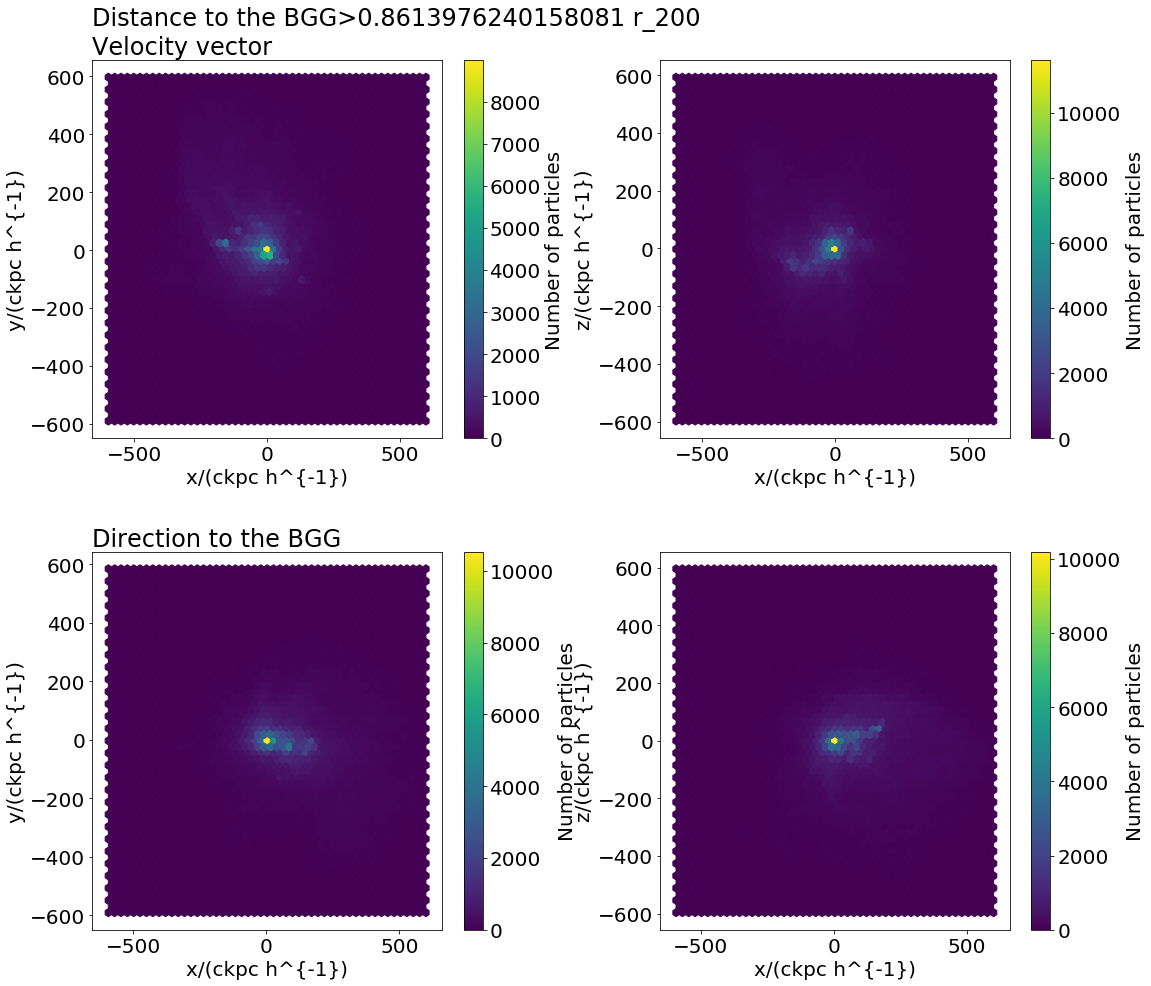

In [36]:
# low distances to the BGG (in r_200)
size = SatR20_2.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatR20_2, CentR20_2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))


pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Distance to the BGG>{} r_200\nVelocity vector'.format(medR20), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

In [8]:
# velocities
Vels = []

for sat, cen in zip(Satellites, Centrals):
    velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][sat]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]
    
    difVel = np.sqrt(np.sum((velGal - velSat)**2))

    Vels.append(difVel)

Vels = np.array(Vels)

In [10]:
medVel = np.median(Vels)
medVel

113.84697

In [11]:
v1, v2 = np.where(Vels<medVel), np.where(Vels>medVel)

SatV1, CentV1 = Satellites[v1], Centrals[v1]
SatV2, CentV2 = Satellites[v2], Centrals[v2]

  1% (7 of 506) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00<ipython-input-6-9794fb2686ee>:71: RuntimeWarning: invalid value encountered in true_divide
  velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
<ipython-input-6-9794fb2686ee>:72: RuntimeWarning: invalid value encountered in true_divide
  xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
 98% (500 of 506) |##################### | Elapsed Time: 0:05:09 ETA:   0:00:00

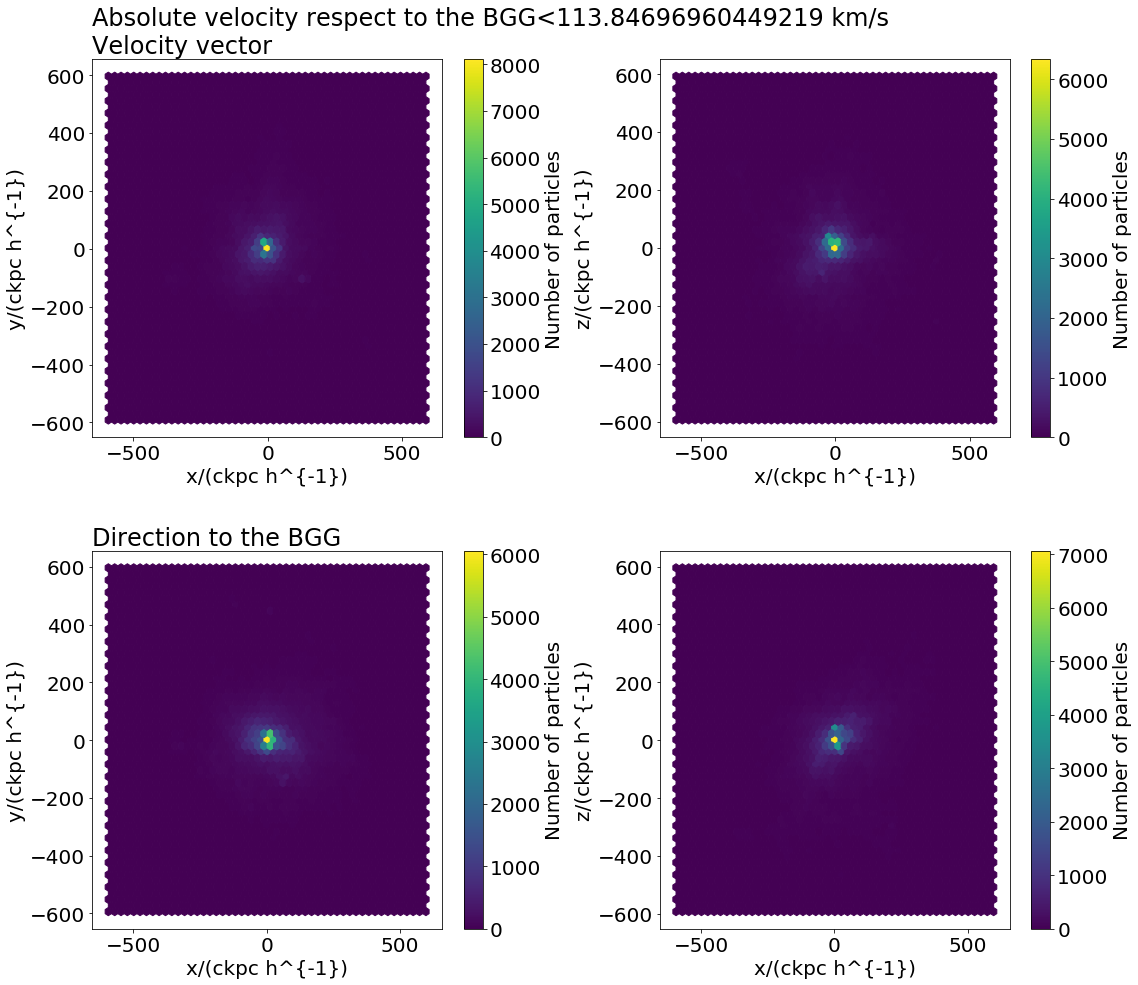

In [12]:
# low speed
size = SatV1.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatV1, CentV1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))


pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Absolute velocity respect to the BGG<{} km/s\nVelocity vector'.format(medVel), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

 99% (505 of 506) |##################### | Elapsed Time: 0:18:18 ETA:   0:00:00

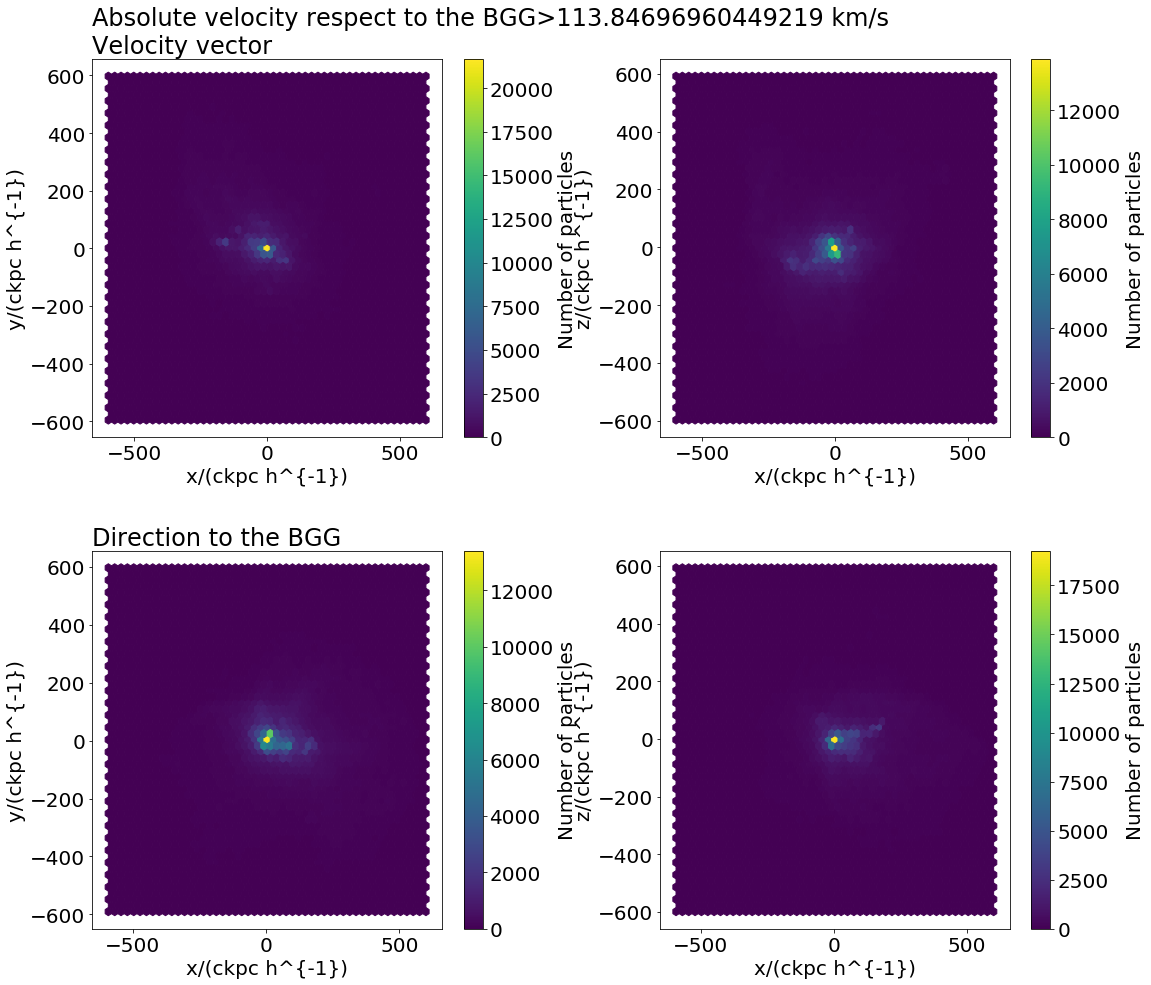

In [13]:
# high speed
size = SatV2.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRv, YRv, ZRv, XRc, YRc, ZRc = [], [], [], [], [], []

for ff, cc in zip(SatV2, CentV2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc = getAllLastP(ff, cc)
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 16))


pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Absolute velocity respect to the BGG>{} km/s\nVelocity vector'.format(medVel), loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the BGG', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

In [ ]:
medVel